In [2]:
import numpy as np
import sys
import nest_asyncio
import math 
from geopy import distance
from math import cos
from math import sin
from math import asin
from math import atan2
from haversine import Unit
from pyproj import Proj
import pyproj
from math import cos, radians

#import rasterio
import random
from natsort import natsorted,realsorted, ns
from tqdm.notebook import trange, tqdm
from time import sleep
import osmnx as ox
import haversine as hs
import shutil
from numpy import asarray
from IPython import display
import os
from os import listdir
import utm
import geopandas
from pathlib import Path
import glob
import concurrent.futures
import geotiler
import cv2 
import matplotlib.pyplot as plt
import h5py
import imutils
import mplleaflet
from PIL import Image, ImageDraw

In [40]:
Logname = 'AtCityBMW_Applanix-20220601T114937Z033'
path = 'C:/Users/bjqb7h/Downloads/Thesis2022/GPS DATA/'
path_position = 'sensors/ApplanixDGPS'
path_orientation = 'sensors/ApplanixDGPS/orientation'
path_timestamps = 'sensors/ApplanixDGPS/timestamps'
path_meta = 'C:/Users/bjqb7h/Downloads/Thesis2022/Meta/'
path_save ='C:/Users/bjqb7h/Downloads/Thesis2022/HD Maps_1/Dataset'
Rdirectory =r'C:\Users\bjqb7h\Downloads\Thesis2022\HD Maps_Rotate'
path_rotate = 'C:/Users/bjqb7h/Downloads/Thesis2022/HD Maps_1/Dataset/'
path_crop ='C:/Users/bjqb7h/Downloads/Thesis2022/HD Maps_Rotate'
path_cropped ='C:/Users/bjqb7h/Downloads/Thesis2022/HD Maps_Cropped'
Sep_path_save ='C:/Users/bjqb7h/Downloads/Thesis2022/HD Maps_1/Dataset/RadarGPS/'
Sep_Rdirectory = r'C:\Users\bjqb7h\Downloads\Thesis2022\HD Maps_Rotate\GPSRADAR\RotatedMAPS'
Sep_path_Rotate = r'C:/Users/bjqb7h/Downloads/Thesis2022/HD Maps_1/Dataset/RadarGPS'
Crop_directory= r'C:/Users/bjqb7h/Downloads/Thesis2022/HD Maps_Rotate/GPSRADAR/RotatedMAPS'
Crop_save_path =r'C:/Users/bjqb7h/Downloads/Thesis2022/HD Maps_Cropped/GPSRADAR'
hDF5_PATH = 'C:/Users/bjqb7h/Downloads/Thesis2022/NUMPY/New'
dir0 = r'C:/Users/bjqb7h/Downloads/Thesis2022/HD Maps_1/Dataset/RadarGPS'
dir1 = 'C:/Users/bjqb7h/Downloads/Thesis2022/HD Maps_Rotate/GPSRADAR/RotatedMAPS'
dir2 = 'C:/Users/bjqb7h/Downloads/Thesis2022/HD Maps_Cropped/GPSRADAR'


In [44]:
#Read Hdf5 filel for the Radar data and GPS data.
hf1 = h5py.File(path+Logname+'.h5','r')
dset = hf1[path_position]['position']
dset1= hf1[path_orientation]
dset2= hf1[path_position]['linearAcceleration']
dsetA = hf1.get(path_timestamps)
GPSTimestamp=np.array(dsetA)



hf2 = h5py.File(path_meta+Logname+'.h5','r')
dsetB= hf2.get('radar_timestamps')
dsetB=np.array(dsetB)
Radar1Timestamp = dsetB[:,0]
Radar1Timestamp = np.round(Radar1Timestamp,2)#RadarTime stamps 
GPSTimestamp= np.round(GPSTimestamp,2)#GPS

Noise_added= 0.0000150 #Range -0.0000150<Noise<0.0000150

#Extract all the Latitudes,Longitude and Orientation(Quaternions) 
Long=dset[:,0] #Longitude
Lat=dset[:,1]  #Latitude
Alt = dset[:,2] #altitude
q0=dset1[:,0]  #Quaternions 1
q1=dset1[:,1]  #Quaternions 2
q2=dset1[:,2]  ##Quaternions 3
q3=dset1[:,3] ##Quaternions 4


lax=dset2[:,0]
lay=dset2[:,1]
laz=dset2[:,2]
size= len(Long) #Size of the dataset ususally len(long)

nest_asyncio.apply()
print(Long.size)

10449


In [43]:
plt.plot(Long,Lat,'r-')
mplleaflet.display()

In [18]:
delimiter = "," # Set the delimiter as a comma

filename = "C:/Users/bjqb7h/Downloads/Thesis2022/gps_data2.txt" # Set the full path of the file

with open(filename, "w") as f:
    for i in range(len(Lat)):
        f.write(str(Long[i]) + delimiter + str(Lat[i]) + "\n")

In [587]:
# GPS data
latitude = Lat  # List of latitudes
longitude = Long  # List of longitudes
timestamps = GPSTimestamp  # List of timestamps in seconds

# Linear acceleration
linear_acceleration = np.array([lax[0], lay[0], laz[0]])  # List of linear accelerations

# Initial position and timestamp
initial_latitude = latitude[0]
initial_longitude = longitude[0]
initial_timestamp = timestamps[0]

acceleration_x = lax  # List of X accelerations
acceleration_y = lay  # List of Y accelerations
acceleration_z = laz

# Convert initial latitude and longitude to UTM
# You can use a library like pyproj for this task
utm_proj = Proj(proj='utm', zone=32, ellps='WGS84')
utm_x, utm_y = utm_proj( initial_longitude,initial_latitude)

# Initial velocity and position
initial_velocity = np.array([0.0, 0.0,0.0])
positionX=np.zeros((len(Long)),dtype =np.float64)
positionY=np.zeros((len(Long)),dtype =np.float64)
positionX[0] = utm_x
positionY[0] = utm_y
velocities = [initial_velocity]

# Projected positions
projected_positionsX = [positionX]
projected_positionsY = [positionY]

for i in range(1, len(timestamps)):
    dt = timestamps[i] - timestamps[i-1]
    #acceleration_gps = np.array([acceleration_x[i], acceleration_y[i], acceleration_z[i]])
    #acceleration_gps = np.dot(R, acceleration)
    coords_1=[Long[i-1],Lat[i-1]]
    coords_2=[Long[i],Lat[i]]
    velocity = (geopy.distance.geodesic(coords_2, coords_1).m)/dt
    velocities.append(velocity)
    positionX[i] = (positionX[i-1] + velocity * dt)
    positionY[i] = (positionY[i-1] + velocity * dt)
    
longitude, latitude = utm_proj(positionX,positionY, inverse=True)
print(longitude[0:2])
print(Long[:2],Lat[:2])

[7.15799338 7.15799494]
[7.15799338 7.15799243] [51.23530091 51.23530124]


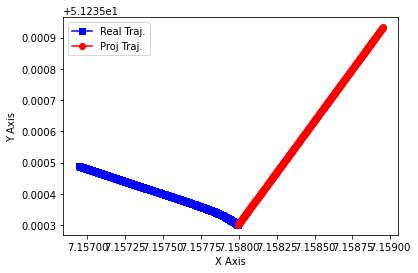

In [588]:
# Create a new figure and axis object
fig, ax = plt.subplots()

# Plot the first set of data points with blue color and square markers
ax.plot(Long[:],Lat[:], 'bs-', label='Real Traj.')

# Plot the second set of data points with red color and circle markers
ax.plot(longitude[:550],latitude[:550], 'ro-', label='Proj Traj.')

# Add a legend to the plot
ax.legend()

# Set the x and y axis labels
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')

# Display the plot
plt.show()



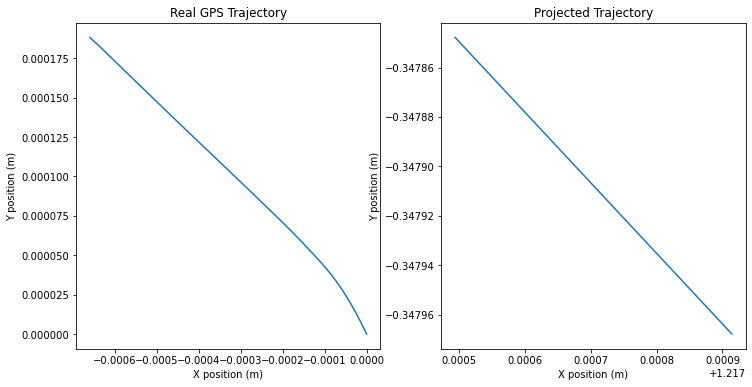

In [21]:
# Define the initial position
init_pos = [Long[0], Lat[0]]

# Convert the GPS coordinates to x and y positions relative to the initial position
x = (Long - init_pos[0])* np.cos(np.radians(Lat[0]))
y = (Lat - init_pos[1])

# Plot the real GPS trajectory
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))

ax[0].plot(x, y)
ax[0].set_xlabel('X position (m)')
ax[0].set_ylabel('Y position (m)')
ax[0].set_title('Real GPS Trajectory')


# Project each GPS point onto the line connecting the first and last GPS points
first_pos = np.array([Long[0], Lat[0]])
last_pos = np.array([Long[-1], Lat[-1]])
proj_vec = last_pos - first_pos
proj_vec = proj_vec / np.linalg.norm(proj_vec)

proj_pos = np.dot(np.column_stack((x, y)) - first_pos, proj_vec)[:, np.newaxis] * proj_vec + first_pos
proj_x = (proj_pos[:, 0] - init_pos[0]) * np.cos(np.radians(Lat[0]))
proj_y = proj_pos[:, 1] - init_pos[1]


# Calculate the difference between the projected and real GPS trajectories
diff_x = x - proj_x
diff_y = y - proj_y


# Plot the projected trajectory
ax[1].plot(proj_x, proj_y)
ax[1].set_xlabel('X position (m)')
ax[1].set_ylabel('Y position (m)')
ax[1].set_title('Projected Trajectory')

plt.show()


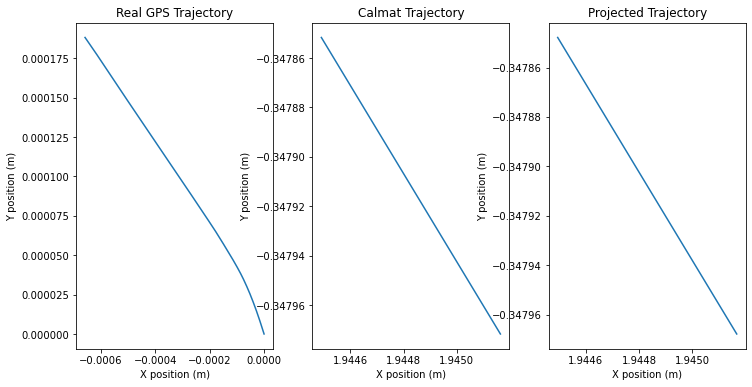

In [30]:
x_transformed =np.zeros((len(Long),1),dtype =np.float64)
y_transformed =np.zeros((len(Long),1),dtype =np.float64)
earth_centre = 6371000   # in meters
dx = (-0.335 / earth_centre)*180/math.pi
dy = (-0.424 / earth_centre)*180/math.pi
dz = (-1.082 / earth_centre)*180/math.pi

T = np.array([[1,0,0,dx],
              [0,1,0,dy],
              [0,0,1,dz],
              [0,0,0,1]])
                
for i in range(size):
    point = np.array([proj_x[i],proj_y[i],1, 1]).reshape((4,1))
    # perform the transformation by multiplying the calibration matrix and the point
    transformed_point = np.matmul(T, point)
    x_transformed[i] = transformed_point[0]
    y_transformed[i] = transformed_point[1]
    
# Plot the real GPS trajectory
fig, ax = plt.subplots(ncols=3, figsize=(12, 6))

ax[0].plot(x, y)
ax[0].set_xlabel('X position (m)')
ax[0].set_ylabel('Y position (m)')
ax[0].set_title('Real GPS Trajectory')

# Plot the projected  calmat trajectory
ax[1].plot(x_transformed, y_transformed)
ax[1].set_xlabel('X position (m)')
ax[1].set_ylabel('Y position (m)')
ax[1].set_title('Calmat Trajectory')

# Plot the projected trajectory
ax[2].plot(proj_x, proj_y)
ax[2].set_xlabel('X position (m)')
ax[2].set_ylabel('Y position (m)')
ax[2].set_title('Projected Trajectory')

plt.show()



c:\users\bjqb7h\miniconda3\envs\perl\lib\site-packages\ipykernel_launcher.py:26: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



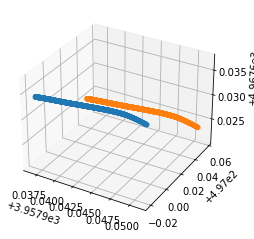

In [648]:
latitude_rad = Lat* np.pi /180
longitude_rad = Long * np.pi /180

x =np.zeros((len(Long),1),dtype =np.float64)
y=np.zeros((len(Long),1),dtype =np.float64)
z=np.zeros((len(Long),1),dtype =np.float64)

x_transformed =np.zeros((len(Long),1),dtype =np.float64)
y_transformed =np.zeros((len(Long),1),dtype =np.float64)
z_transformed=np.zeros((len(Long),1),dtype =np.float64)
R=6371

calibration_matrix = np.array([[1,0.0000016,0.0000012,0.000516],
                               [0.0000012,1,-0.0000016,0.000426],
                               [0.0000012,-0.0000016,1,-0.000882],
                               [0, 0, 0, 1]])

for i in range(len(Long)):
    x[i] = R* cos(latitude_rad[i]) * cos(longitude_rad[i])
    y[i] = R * cos(latitude_rad[i]) * sin(longitude_rad[i])
    z[i] = R * sin(latitude_rad[i])
    

# define your original point as a 4x1 homogeneous coordinate vector
for i in range(len(Long)):
    point = np.array([x[i], y[i], z[i], 1]).reshape((4,1))
# perform the transformation by multiplying the calibration matrix and the point
    transformed_point = np.matmul(calibration_matrix, point)
# convert the transformed point back to Cartesian coordinates
    x_transformed[i] = transformed_point[0] / transformed_point[3]
    y_transformed[i] = transformed_point[1] / transformed_point[3]
    z_transformed[i] = transformed_point[2] / transformed_point[3]

ax = plt.axes(projection='3d')
ax.scatter3D(x,y, z, 'blue')
ax.scatter3D(x_transformed,y_transformed,z_transformed, 'gray')

In [649]:
#Convert the points back to degree decimal
R=6371
latitude1 =np.zeros((len(Long),1),dtype =np.float64)
longitude1=np.zeros((len(Long),1),dtype =np.float64)
La1 =np.zeros((len(Long),1),dtype =np.float64)
Lo1 =np.zeros((len(Long),1),dtype =np.float64)
for i in range(len(La1)):
    latitude1[i] = asin(z[i]/R)
    longitude1[i] = atan2(y[i],x[i])
    La1[i]=asin(z_transformed[i]/R)
    Lo1[i] = atan2(y_transformed[i],x_transformed[i])

LaT1 = latitude1*180/np.pi
LonG1 = longitude1*180/np.pi

NewLat = La1*180/np.pi
NewLong = Lo1*180/np.pi


plt.plot(NewLong,NewLat,'r-')
plt.plot(LonG1,LaT1,'b-')
plt.plot(longitude[:550],latitude[:550])
mplleaflet.display()
       

In [569]:
def transform_to_imu_frame(calibration_matrix, raw_dgps_data):
    # convert raw DGPS data into a 4x1 matrix
    raw_dgps_data = np.append(raw_dgps_data, [1])
    raw_dgps_data = raw_dgps_data.reshape((4,1))
    # multiply the calibration matrix and raw DGPS data to get the transformed data in IMU frame
    transformed_data = np.dot(calibration_matrix,raw_dgps_data)
    # return the transformed data (without the last row)
    return transformed_data[:3,0]



result = np.zeros((x.shape[0], 3))
for i in range(x.shape[0]):
    gps_coordinates = np.array([x[i], y[i], z[i]])
    result[i,:] =transform_to_imu_frame(calibration_matrix,gps_coordinates)
    


# # The result is the Cartesian coordinates in the vehicle frame
x_vehicle = result[:,0]
y_vehicle = result[:,1]
z_vehicle = result[:,2]



R=6371
La1 =np.zeros((len(Long),1),dtype =np.float64)
Lo1 =np.zeros((len(Long),1),dtype =np.float64)
for i in range(len(La1)):
    La1[i] = asin(z_vehicle[i]/R)
    Lo1[i] = atan2(y_vehicle[i],x_vehicle[i])
    
NewLat = La1*180/np.pi
NewLong = Lo1*180/np.pi

In [642]:
plt.plot(NewLong,NewLat,'r-')
plt.plot(Long,Lat,'b-')
mplleaflet.display()

In [650]:
#Original Calibration matrix

from numpy import pi

phi = -0.210 * pi / 180.0
theta = 0.100 * pi / 180.0
psi = -0.229 * pi / 180.0

R_imu_ref = np.array([[cos(theta)*cos(psi), -cos(phi)*sin(psi)+sin(phi)*sin(theta)*cos(psi), sin(phi)*sin(psi)+cos(phi)*sin(theta)*cos(psi)],
             [cos(theta)*sin(psi), cos(phi)*cos(psi)+sin(phi)*sin(theta)*sin(psi), -sin(phi)*cos(psi)+cos(phi)*sin(theta)*sin(psi)],
             [-sin(theta), sin(phi)*cos(theta), cos(phi)*cos(theta)]])



(3, 3)


In [254]:
phi1 = 0.0 * pi / 180.0
theta1 = 0.0 * pi / 180.0
psi1 = 0.0 * pi / 180.0

R_ref_vehicle =  np.array([[cos(theta1)*cos(psi1), -cos(phi1)*sin(psi1)+sin(phi1)*sin(theta1)*cos(psi1), sin(phi1)*sin(psi1)+cos(phi1)*sin(theta1)*cos(psi1)],
                 [cos(theta1)*sin(psi1), cos(phi1)*cos(psi1)+sin(phi1)*sin(theta1)*sin(psi1), -sin(phi1)*cos(psi1)+cos(phi1)*sin(theta1)*sin(psi1)],
                 [-sin(theta1), sin(phi1)*cos(theta1), cos(phi1)*cos(theta1)]])

In [256]:
R_imu_vehicle = R_ref_vehicle.dot(R_imu_ref)
t_imu_gnss = np.array([-0.181, -0.001, -0.206])
t_gnss_vehicle = np.array([0.335, -0.424, -1.082])

In [258]:
calib_matrix = np.eye(4)
calib_matrix[0:3, 0:3] = R_imu_vehicle
calib_matrix[0:3, 3] = t_gnss_vehicle - R_imu_vehicle.dot(t_imu_gnss)
print(calib_matrix)

[[ 0.99999049  0.00399037  0.00175995  0.51635426]
 [-0.00399679  0.99998532  0.00365818 -0.4229918 ]
 [-0.00174533 -0.00366518  0.99999176 -0.88232122]
 [ 0.          0.          0.          1.        ]]
